<a href="https://colab.research.google.com/github/madeshmahadev/Group_6_SEP_769_Project_Source_Code/blob/main/Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEP 769 - DL Project Source Code

### Project No: 6
### Title: Water Quality Detection

### Project Members:
- Bansi Patel - patelb52@mcmaster.ca
- Marvel Rodriguez - 400419918 - rodrin33@mcmaster.ca
- Mahadev K - 400416114 - km@mcmaster.ca

### Dataset:
- Dataset Link: https://www.kaggle.com/datasets/adityakadiwal/water-potability
- Number of Columns: 10
- Number of Rows: 3276

---
## Importing Essential Libraries




In [56]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for finding each Model's Metrics and perform Evaluation 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

## Importing Classification Models
from sklearn.neighbors import KNeighborsClassifier # Loading K-Nearest Neighbors (KNN)
from sklearn.naive_bayes import GaussianNB # Loading GNB Classifier
from sklearn.ensemble import RandomForestClassifier # Loading Random-Forest Classifer

# To ignore non-error warnings
import warnings
warnings.filterwarnings('ignore')

---

## Importing Dataset





### Dataset Description

- **pH** : Indicator of acidic or alkaline condition of water, ranging from 1 to 14. *Acceptable Limit: 6.5 to 8.5*

- **Hardness** : Capacity of water to precipitate soap in mg/L. *Acceptable Limit: Upto 500 or 600 mg/L*

- **Solids** : Total dissolved solids (TDS) in ppm. The water with high TDS value indicates that water is highly mineralized. *Acceptable Limit: 500 - 1000 ppm*

- **Chloramines** : Amount of Chloramines in ppm. *Acceptable Limit: Upto 4 ppm*

- **Sulfate** : Amount of Sulfates dissolved in water in mg/L. *Acceptable Limit: Upto 400 mg/L*

- **Conductivity** : Electrical conductivity of water in μS/cm.* Acceptable Limit: Upto 400 μS/cm*

- **Organic_carbon** : Amount of carbon in organic compounds in ppm. *Acceptable Limit: Less than 2 mg/L*

- **Trihalomethanes**: Amount of Trihalomethanes in μg/L. *Acceptable Limit: Upto 80 ppm*

- **Turbidity**: Measure of light emiting property of water in NTU. *Acceptable Limit: 5-10 NTU*

- **Potability**: Indicates if water is safe for human consumption. *1 -> Potable & 0 - Not Potable*

In [57]:
# Initializing data frame
dataset = pd.read_csv('water_potability.csv')

# Shape of the dataset
print("\n Rows x Cols")
print(dataset.shape)

# Sample records from the dataset
print("\n First five records from the dataset")
print(dataset.head())


 Rows x Cols
(3276, 10)

 First five records from the dataset
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  


---
## Exploratory Data Analysis (EDA) & Data Preprocessing

#### 1. Plotting Subplot

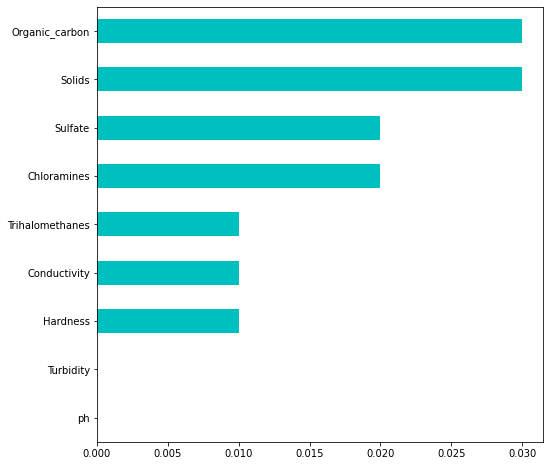

In [58]:
fig,ax = plt.subplots(figsize=(8,8))
abs(dataset.corr().round(2)['Potability']).sort_values()[:-1].plot.barh(color='c')

#### 2. Plotting Histogram

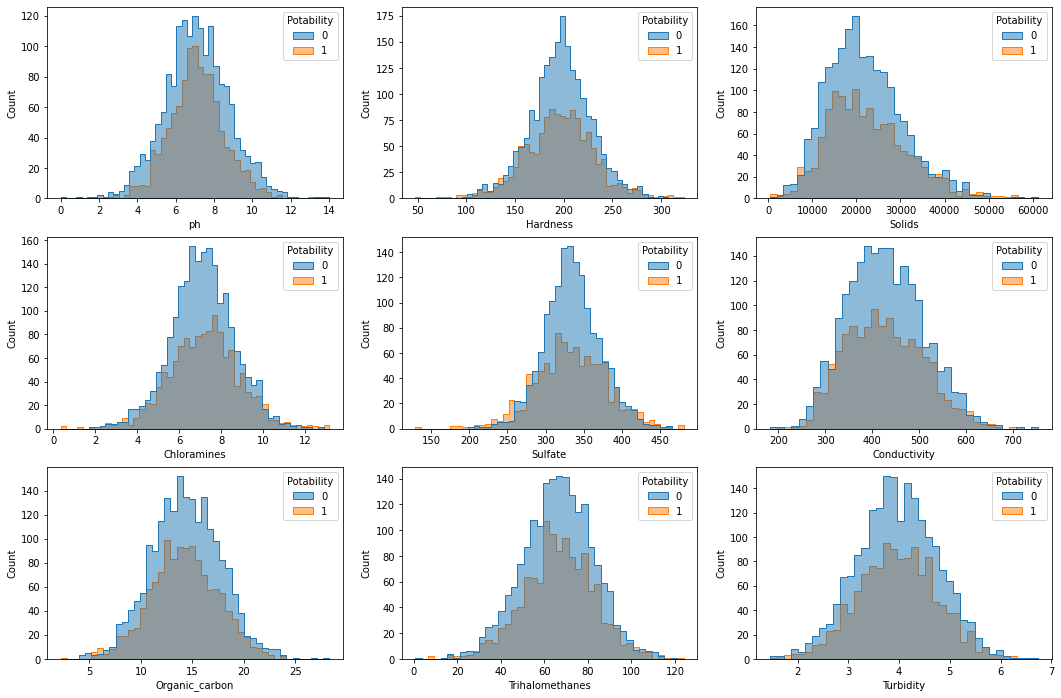

In [59]:
plt.figure(figsize=(18,12))
for i, feature in enumerate(dataset.columns):
    if feature != 'Potability':
        plt.subplot(3,3,i+1)
        sns.histplot(data = dataset, x=feature, hue = 'Potability', element="step", alpha = 0.5 )

#### 3. Plotting Pairplot

<Figure size 720x360 with 0 Axes>

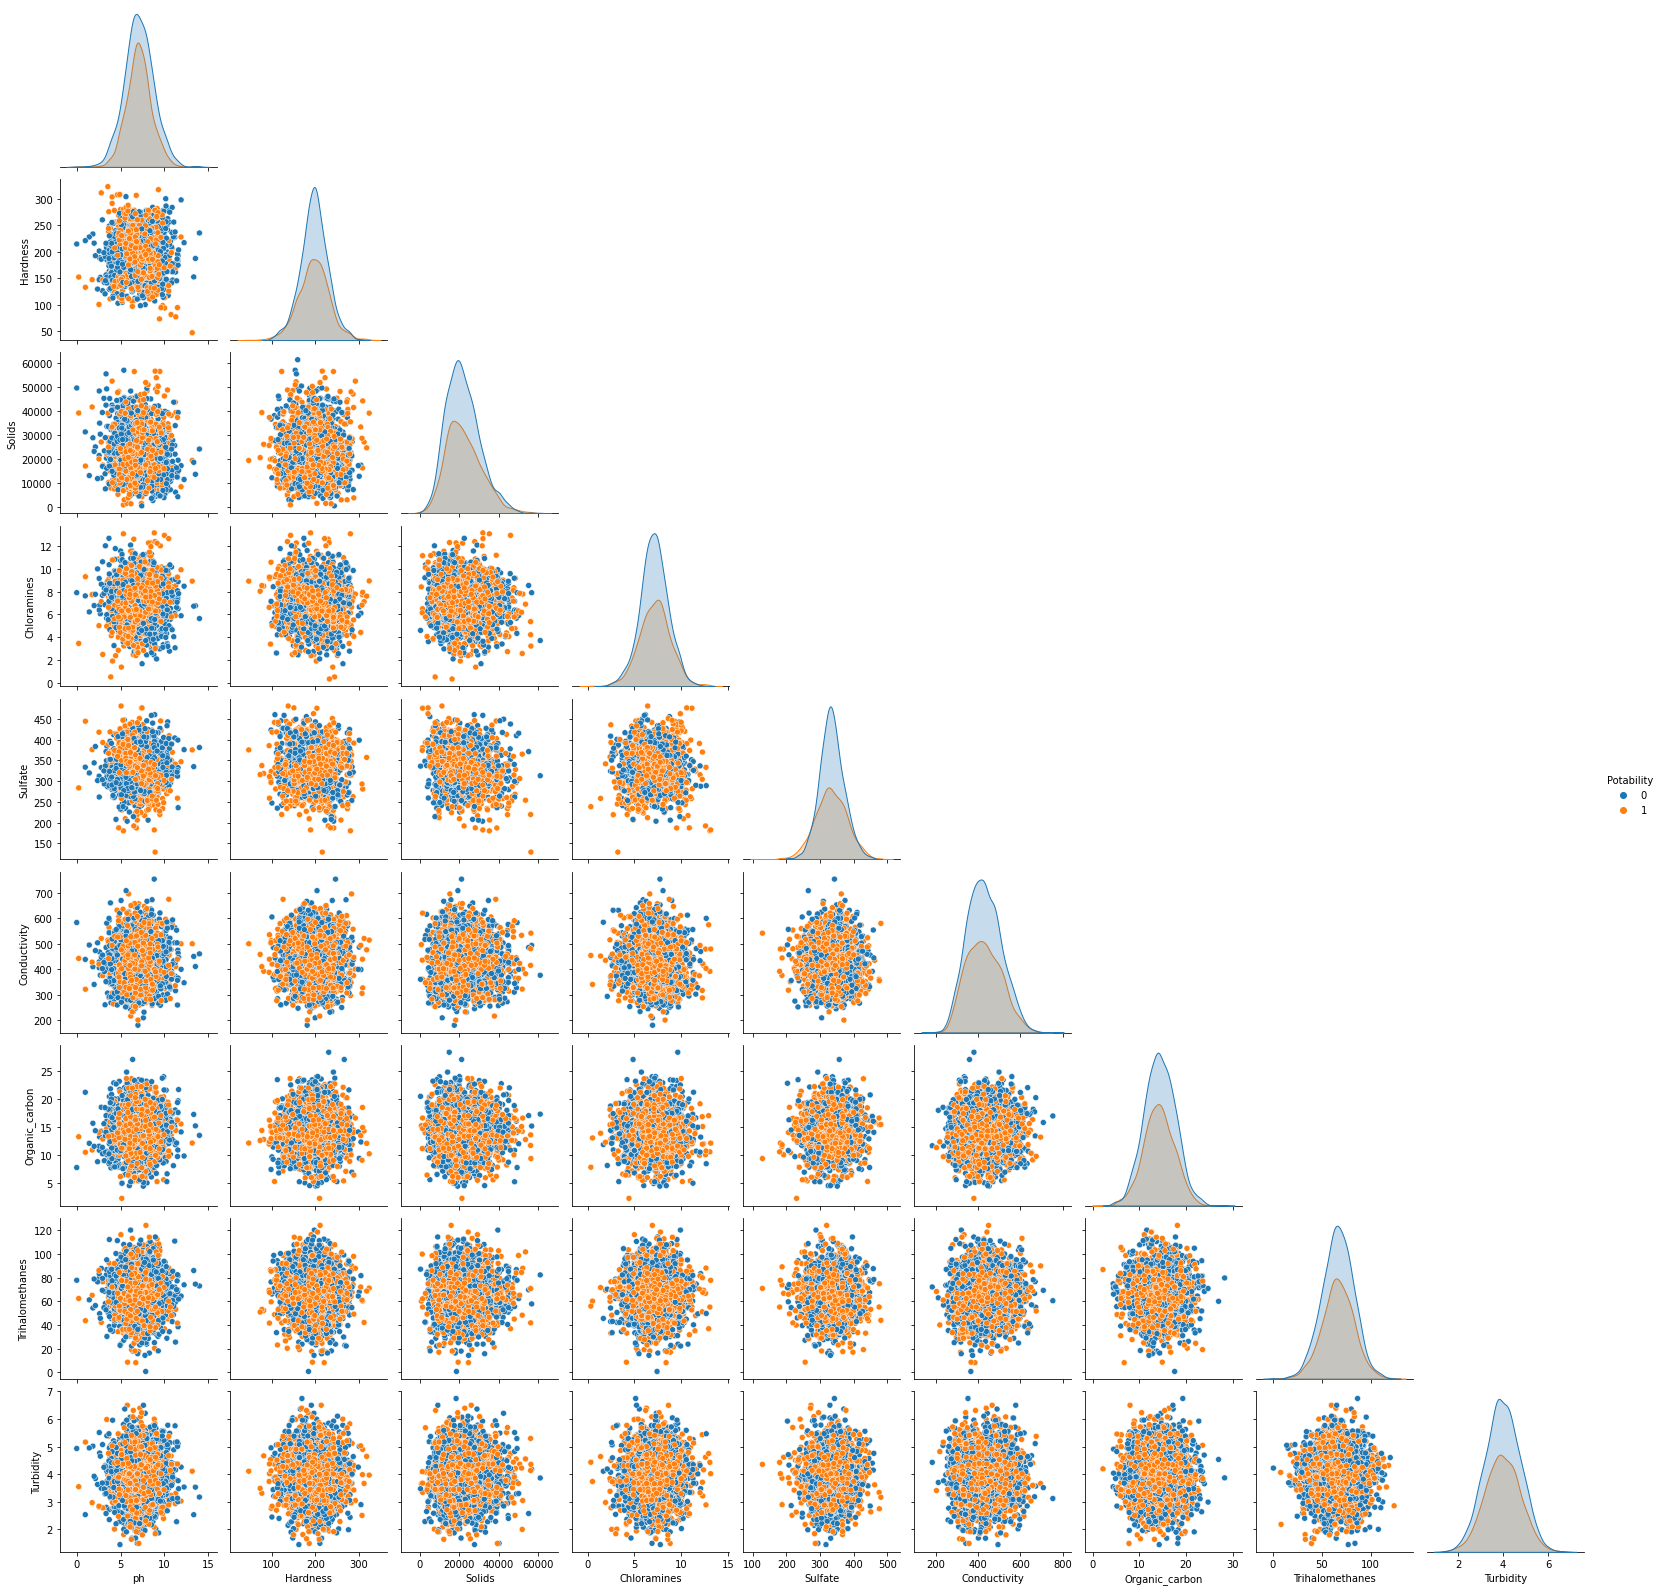

In [60]:
plt.figure(figsize=(10,5))
sns.pairplot(data = dataset, hue = 'Potability', corner=True)

#### 4. Plotting Correlation before handling missing values 

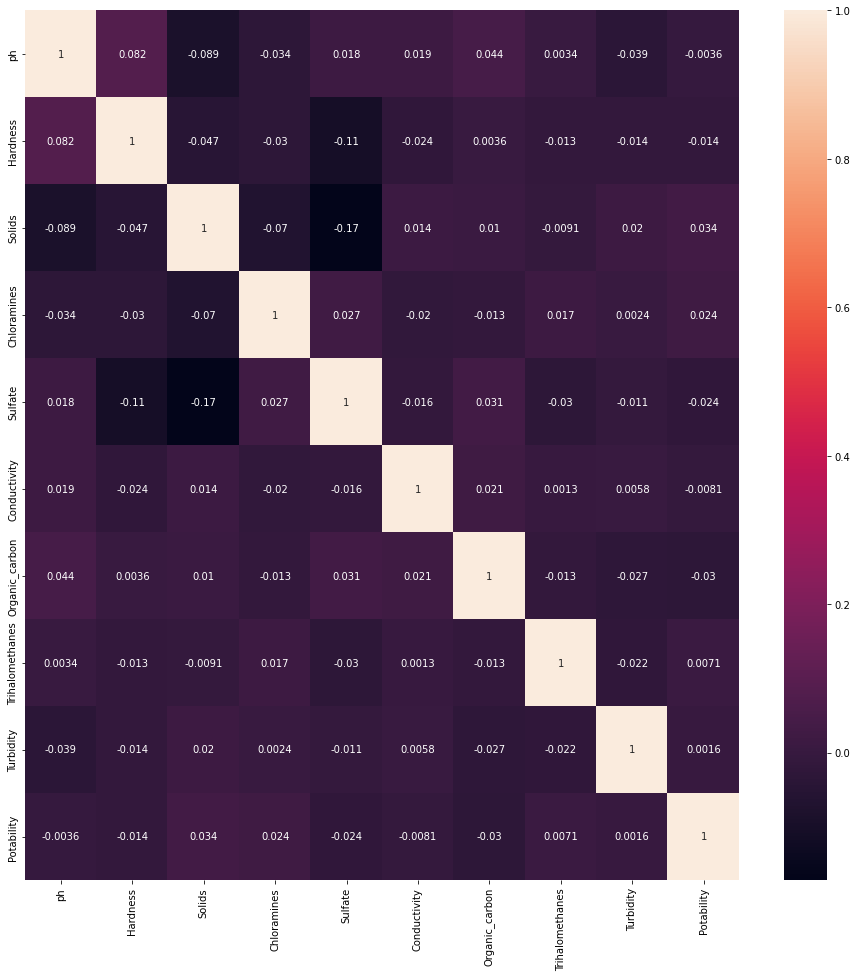

In [61]:
fig,ax = plt.subplots(figsize=(16,16))
sns.heatmap(dataset.corr(), ax = ax, annot = True)

#### 5. Handling Missing Values & Imputing values using Simple Imputer 

In [62]:
# Finding the precence of Null values in the Dataset
dataset.isnull().sum().sort_values(ascending=False)

Sulfate            781
ph                 491
Trihalomethanes    162
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
dtype: int64

In [63]:
# Finding the percentage of Null values for each Feature
null_values_percentage = dataset.isnull().sum() * 100 / len(dataset)
null_values_percentage_DF = pd.DataFrame({'Feature': dataset.columns,'Null_Values_%': null_values_percentage})
null_values_percentage_DF.sort_values(by='Null_Values_%', ascending=False)

,Feature,Null_Values_%
Sulfate,Sulfate,23.840049
ph,ph,14.987790
Trihalomethanes,Trihalomethanes,4.945055
Hardness,Hardness,0.000000
Solids,Solids,0.000000
Chloramines,Chloramines,0.000000
Conductivity,Conductivity,0.000000
Organic_carbon,Organic_carbon,0.000000
Turbidity,Turbidity,0.000000
Potability,Potability,0.000000


In [64]:
# Counting the rows associated with each target class
dataset["Potability"].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [65]:
# Finding the mean value for all the features with respective to each target values.
dataset.groupby('Potability').mean()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
Potability,,,,,,,,,
0,7.085378,196.733292,21777.490788,7.092175,334.56429,426.730454,14.364335,66.303555,3.965800
1,7.073783,195.800744,22383.991018,7.169338,332.56699,425.383800,14.160893,66.539684,3.968328


- The columns ph, Sulfate and Trihalomethanes have null values. 
- Since we could not afford to remove these datapoints as the dataset contains only 3276 entries, we are replacing them with their mean values.
- To achieve this we are using a scikit-learn class to impute the missing values.


In [66]:
dataset[:] = SimpleImputer(strategy='mean').fit_transform(dataset)

In [67]:
# Checking if there are missing values after Imputing
dataset.isnull().sum().sort_values(ascending=False)

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

#### 5.a. Plotting Correlation after handling missing values

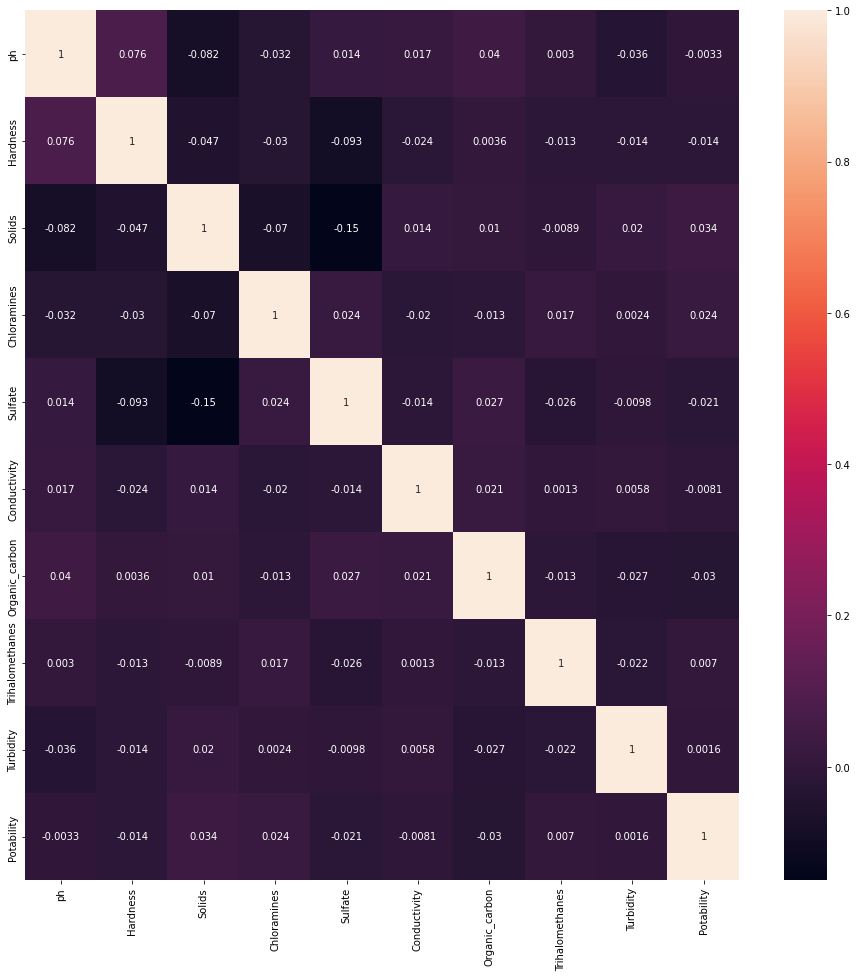

In [68]:
fig,ax = plt.subplots(figsize=(16,16))
sns.heatmap(dataset.corr(), ax = ax, annot = True)

#### 6. Normalizing Data - Using Min-Max Scaling

In [69]:
minMaxScaler = preprocessing.MinMaxScaler()
scaled_dataset = pd.DataFrame(minMaxScaler.fit_transform(dataset), columns=dataset.columns)

In [70]:
scaled_dataset.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.505771,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.581699,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.581699,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0


#### 7. Comparing Original Dataset with the Scaled Dataset

Text(0.5, 1.0, 'Scaled Dataset')

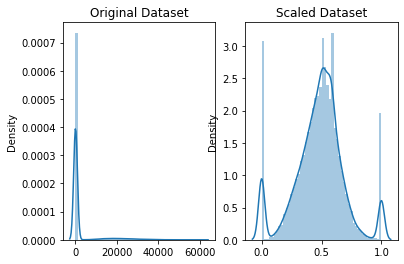

<Figure size 1296x864 with 0 Axes>

In [71]:
# plot both together to compare
fig, ax=plt.subplots(1,2)
plt.figure(figsize=(18,12))
sns.distplot(dataset, ax=ax[0])
ax[0].set_title("Original Dataset")
sns.distplot(scaled_dataset, ax=ax[1])
ax[1].set_title("Scaled Dataset")


---
## Creating Training & Testing sets

#### Extracting features and target from Dataset

In [72]:
dataset_features = scaled_dataset.drop(['Potability'], axis=1)
dataset_target = scaled_dataset["Potability"]

print("\nShape of the Features: ", dataset_features.shape)
print("\nShape of the Target: ", dataset_target.shape)


Shape of the Features:  (3276, 9)

Shape of the Target:  (3276,)


In [73]:
# Data Split -> Train: 75% & Testing: 25%
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_target, test_size = 0.25, random_state = 42)

In [74]:
print("\nShape of the X_train: ", X_train.shape)
print("\nShape of the Y_train: ", y_train.shape)
print("\nShape of the X_test: ", X_test.shape)
print("\nShape of the Y_test: ", y_test.shape)


Shape of the X_train:  (2457, 9)

Shape of the Y_train:  (2457,)

Shape of the X_test:  (819, 9)

Shape of the Y_test:  (819,)



---
## Classification with KNN, GNB & RF classifiers


### Classification with KNN Classifier

KNN Classifier
Accuracy         :  0.632
Precision        :  0.657
Recall           :  0.632
F1 Score         :  0.632

Cross Validation :  [0.61788618 0.61788618 0.63414634 0.6097561  0.6097561  0.61382114
 0.62195122 0.62857143 0.6122449  0.61632653]

Confusion Matrix : 
 [[504   6]
 [295  14]]

R-square value : 0.632

Plotting KNN ROC Curve:


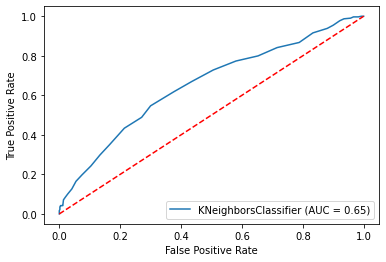

In [100]:
# Training a KNN classifier with 100 neighbors
k_neighbors = 105 # (Number of nearest neighbors)

# Model Fit
KNN_model = KNeighborsClassifier(n_neighbors = k_neighbors).fit(X_train, y_train);

# Model Predict
KNN_y_predicted = KNN_model.predict(X_test)

# Model Evaluation
KNN_Accuracy         = accuracy_score(y_test, KNN_y_predicted)
KNN_Recall           = recall_score(y_test, KNN_y_predicted, average = "weighted")
KNN_Precision        = precision_score(y_test, KNN_y_predicted, average = "weighted")
KNN_Score            = f1_score(y_test, KNN_y_predicted, average = 'micro')
KNN_Cross_Val        = cross_val_score(KNeighborsClassifier(n_neighbors = k_neighbors), X_train, y_train, cv = 10)
KNN_Confusion_Matrix = confusion_matrix(y_test, KNN_y_predicted)

# Displaying Outputs
print("KNN Classifier")
print("Accuracy         : ", round(KNN_Accuracy, 3))
print("Precision        : ", round(KNN_Precision, 3))
print("Recall           : ", round(KNN_Recall, 3))
print("F1 Score         : ", round(KNN_Score, 3))
print("\nCross Validation : ", KNN_Cross_Val)
print("\nConfusion Matrix : \n", KNN_Confusion_Matrix)
print("\nR-square value : {:.3f}".format(KNN_model.score(X_test, y_test)))
print("\nPlotting KNN ROC Curve:")
metrics.plot_roc_curve(KNN_model, X_test, y_test)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Classification with Gaussian Naive Bayes (GNB) Classifier

Gaussian Naive Bayes (GNB)
Accuracy         :  0.636
Precision        :  0.612
Recall           :  0.636
F1 Score         :  0.636

Cross Validation :  [0.6097561  0.6097561  0.66260163 0.59756098 0.6097561  0.60569106
 0.62601626 0.61632653 0.6122449  0.62857143]

Confusion Matrix : 
 [[455  55]
 [243  66]]

R-square value   : 0.636

Plotting GNB ROC Curve:


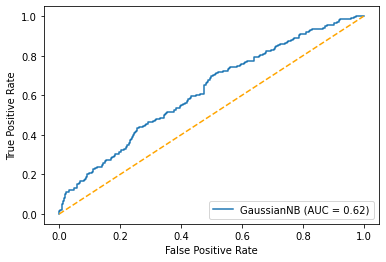

In [101]:
#  Creating Model with configuration
GNB_model = GaussianNB()

# Model Fit
GNB_model.fit(X = X_train, y = y_train)

# Model Predict
GNB_y_predicted = GNB_model.predict(X_test) 

# Model Evaluation
GNB_Accuracy         = accuracy_score(y_test, GNB_y_predicted)
GNB_Recall           = recall_score(y_test, GNB_y_predicted, average = "weighted")
GNB_Precision        = precision_score(y_test, GNB_y_predicted, average = "weighted")
GNB_Score            = f1_score(y_test, GNB_y_predicted, average = 'micro')
GNB_Cross_Val        = cross_val_score(GNB_model, X_train, y_train, cv = 10)
GNB_Confusion_Matrix = confusion_matrix(y_test, GNB_y_predicted)

# Displaying Outputs
print("Gaussian Naive Bayes (GNB)")
print("Accuracy         : ", round(GNB_Accuracy,3))
print("Precision        : ", round(GNB_Precision,3))
print("Recall           : ", round(GNB_Recall,3))
print("F1 Score         : ", round(GNB_Score,3))
print("\nCross Validation : ", GNB_Cross_Val)
print("\nConfusion Matrix : \n", GNB_Confusion_Matrix)
print("\nR-square value   : {:.3f}".format(GNB_model.score(X_test, y_test)))
print("\nPlotting GNB ROC Curve:")
metrics.plot_roc_curve(GNB_model, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Classification with Random Forest Classifier

Random Forest
Accuracy         :  0.676
Precision        :  0.665
Recall           :  0.676
F1 Score         :  0.676

Cross Validation :  [0.66260163 0.64634146 0.68292683 0.66260163 0.64634146 0.63414634
 0.67479675 0.65714286 0.69387755 0.66122449]

Confusion Matrix : 
 [[441  69]
 [196 113]]

R-square value   : 0.676

 Plotting Random Forest ROC Curve:


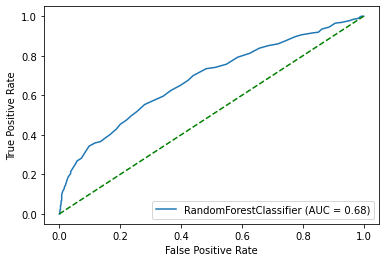

In [102]:
# Creating Model with configuration
RF_Model = RandomForestClassifier(n_estimators=100)

# Model Fit
RF_Model.fit(X = X_train, y = y_train)

# Model Predict
RF_y_predicted      = RF_Model.predict(X_test)

# Model Evaluation
RF_Accuracy         = accuracy_score(y_test, RF_y_predicted)
RF_Recall           = recall_score(y_test, RF_y_predicted, average = "weighted")
RF_Precision        = precision_score(y_test, RF_y_predicted, average = "weighted")
RF_Score            = f1_score(y_test, RF_y_predicted, average = 'micro')
RF_Cross_Val        = cross_val_score(RF_Model, X_train, y_train, cv = 10)
RF_Confusion_Matrix = confusion_matrix(y_test, RF_y_predicted)

# Displaying Outputs
print("Random Forest")
print("Accuracy         : ", round(RF_Accuracy, 3))
print("Precision        : ", round(RF_Precision, 3))
print("Recall           : ", round(RF_Recall, 3))
print("F1 Score         : ", round(RF_Score, 3))
print("\nCross Validation : ", RF_Cross_Val)
print("\nConfusion Matrix : \n", RF_Confusion_Matrix)
print("\nR-square value   : {:.3f}".format(RF_Model.score(X_test, y_test)))
print("\n Plotting Random Forest ROC Curve:")
metrics.plot_roc_curve(RF_Model, X_test, y_test)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Tuning Random Forest Model  

In [93]:
RF_params = {"max_depth": [2,5,8,10],
             "max_features": [5,6,7,8],
             "n_estimators": [10, 100],
             "min_samples_split": [2, 5, 10]}
                        
RF_Model = RandomForestClassifier()

# Finding best parameter values from the above defined params using GridSearchCV
RF_CV_model = GridSearchCV(RF_Model, RF_params, cv=10, n_jobs=-1, verbose=2)

# Model Fit
RF_CV_model.fit(X_train, y_train)

# Displaying Best Parameters
print("Best Parameters:", RF_CV_model.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best Parameters: {'max_depth': 10, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 100}


RF (Tuned)
Accuracy         :  0.691
Precision        :  0.697
Recall           :  0.691
F1 Score         :  0.691

Cross Validation :  [0.6504065  0.65447154 0.69105691 0.67073171 0.64227642 0.65447154
 0.68292683 0.66122449 0.72244898 0.67346939]

Confusion Matrix : 
 [[473  37]
 [216  93]]

R-square value   : 0.691

 Plotting Random Forest ROC Curve:


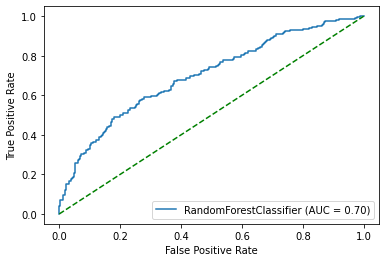

In [103]:
# Creating the Tuned Model with configuration
RF_Tuned_Model =  RandomForestClassifier(max_depth = 10, max_features = 8, min_samples_split = 2, n_estimators = 100)

# Model Fit
RF_Tuned_Model.fit(X = X_train, y = y_train)

# Model Predict
RF_Tuned_y_predicted      = RF_Tuned_Model.predict(X_test)

# Model Evaluation
RF_Tuned_Accuracy         = accuracy_score(y_test, RF_Tuned_y_predicted)
RF_Tuned_Recall           = recall_score(y_test, RF_Tuned_y_predicted, average = "weighted")
RF_Tuned_Precision        = precision_score(y_test, RF_Tuned_y_predicted, average = "weighted")
RF_Tuned_Score            = f1_score(y_test, RF_Tuned_y_predicted, average = 'micro')
RF_Tuned_Cross_Val        = cross_val_score(RF_Tuned_Model, X_train, y_train, cv = 10)
RF_Tuned_Confusion_Matrix = confusion_matrix(y_test, RF_Tuned_y_predicted)

# Displaying Outputs
print("RF (Tuned)")
print("Accuracy         : ", round(RF_Tuned_Accuracy, 3))
print("Precision        : ", round(RF_Tuned_Precision, 3))
print("Recall           : ", round(RF_Tuned_Recall, 3))
print("F1 Score         : ", round(RF_Tuned_Score, 3))
print("\nCross Validation : ", RF_Tuned_Cross_Val)
print("\nConfusion Matrix : \n", RF_Tuned_Confusion_Matrix)
print("\nR-square value   : {:.3f}".format(RF_Tuned_Model.score(X_test, y_test)))
print("\n Plotting Random Forest ROC Curve:")
metrics.plot_roc_curve(RF_Tuned_Model, X_test, y_test)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

---
## Evaluating above used Classification Model



### Comparing Accuracies - KNN vs GNB vs RF (Tuned)

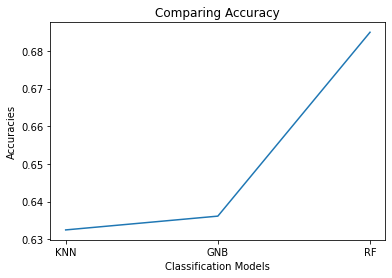

In [80]:
Classification_Models = ['KNN','GNB','RF']
Accuracies = [KNN_Accuracy, GNB_Accuracy, RF_Tuned_Accuracy]
plt.plot(Classification_Models, Accuracies)
plt.title('Comparing Accuracy')
plt.xlabel('Classification Models')
plt.ylabel('Accuracies')
plt.show()

### Comparing Precision - KNN vs GNB vs RF (Tuned)

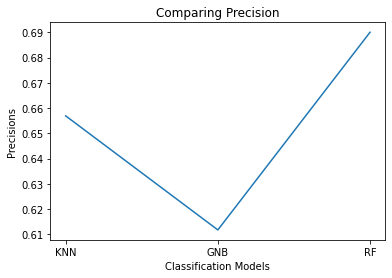

In [81]:
Classification_Models = ['KNN','GNB','RF']
Precisions = [KNN_Precision, GNB_Precision, RF_Tuned_Precision]
plt.plot(Classification_Models, Precisions)
plt.title('Comparing Precision')
plt.xlabel('Classification Models')
plt.ylabel('Precisions')
plt.show()

### Comparing Recall - KNN vs GNB vs RF

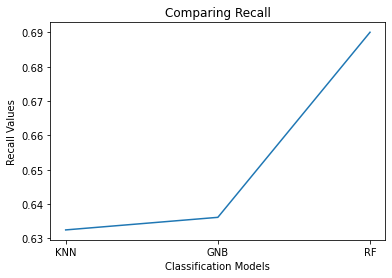

In [82]:
Classification_Models = ['KNN','GNB','RF']
Precisions = [KNN_Recall, GNB_Recall, RF_Tuned_Precision]
plt.plot(Classification_Models, Precisions)
plt.title('Comparing Recall')
plt.xlabel('Classification Models')
plt.ylabel('Recall Values')
plt.show()

### Comparing F1 Scores - KNN vs GNB vs RF

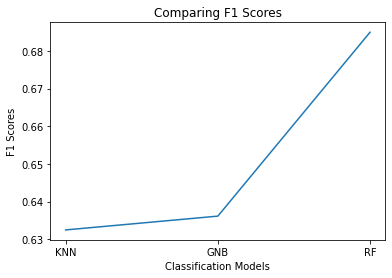

In [83]:
Classification_Models = ['KNN','GNB','RF']
F1_Scores = [KNN_Score, GNB_Score, RF_Tuned_Score]
plt.plot(Classification_Models, F1_Scores)
plt.title('Comparing F1 Scores')
plt.xlabel('Classification Models')
plt.ylabel('F1 Scores')
plt.show()

### Comparing Cross-Validations - KNN vs GNB vs RF

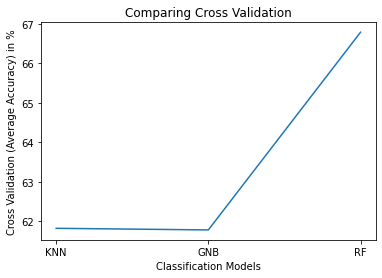

In [84]:
Classification_Models = ['KNN','GNB','RF']
Cross_Validation_AVG = [(sum(KNN_Cross_Val)/len(KNN_Cross_Val))*100, (sum(GNB_Cross_Val)/len(GNB_Cross_Val))*100, (sum(RF_Cross_Val)/len(RF_Cross_Val))*100]
plt.plot(Classification_Models, Cross_Validation_AVG)
plt.title('Comparing Cross Validation')
plt.xlabel('Classification Models')
plt.ylabel('Cross Validation (Average Accuracy) in %')
plt.show()

### Plotting Confusion Matrix

Plotting for KNN


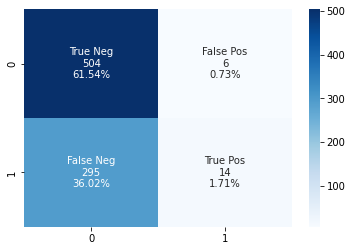

In [95]:
print("Plotting for KNN")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in KNN_Confusion_Matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in KNN_Confusion_Matrix.flatten()/np.sum(KNN_Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(KNN_Confusion_Matrix, annot=labels, fmt='', cmap='Blues')

Plotting for GNB


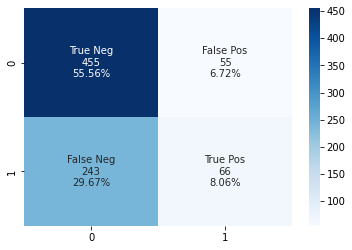

In [96]:
print("Plotting for GNB")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in GNB_Confusion_Matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in GNB_Confusion_Matrix.flatten()/np.sum(GNB_Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(GNB_Confusion_Matrix, annot=labels, fmt='', cmap='Blues')

Plotting for RF


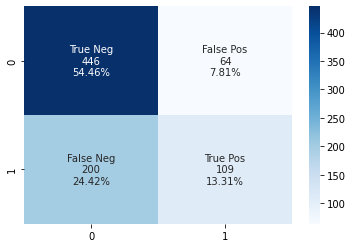

In [97]:
print("Plotting for RF")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in RF_Confusion_Matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in RF_Confusion_Matrix.flatten()/np.sum(RF_Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RF_Confusion_Matrix, annot=labels, fmt='', cmap='Blues')

Plotting for RF (Tuned)


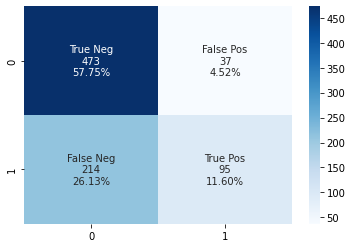

In [98]:
print("Plotting for RF (Tuned)")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in RF_Tuned_Confusion_Matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in RF_Tuned_Confusion_Matrix.flatten()/np.sum(RF_Tuned_Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RF_Tuned_Confusion_Matrix, annot=labels, fmt='', cmap='Blues')


---
## Saving & Loading Model




In [89]:
# To save the searialized format of the RF-Tuned Model
import pickle

# Saving the model to the disk
pickle.dump(RF_Tuned_Model, open('RF_Tuned_model.sav', 'wb'))

# Loading the saved model
Model = pickle.load(open('RF_Tuned_model.sav', 'rb'))

In [90]:
# Testing the Loaded Model
print("Model Accuracy: ", round(Model.score(X_test, y_test),2), "%")

Model Accuracy:  0.68 %


In [91]:
# Testing with Data
ph = 7.5
hardness = 520
solids = 600
chloramines = 3
sulfate = 311
conductivity = 321
organic_carbon = 2
trihalomethanes = 80
turbidity = 6

Test_Input = pd.DataFrame([[ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, trihalomethanes, turbidity]])

if  Model.predict(Test_Input)[0] == 1:
  print("Water is Potable")
else:
  print("Water is not Potable")

Water is not Potable
